In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score
import pickle


In [45]:
import pandas as pd

# Load the modified dataset
file_path = 'C:\\Users\\ARUN ROSHAN\\patient-care-analysis\\datasets\\Modified_Book1.csv'  # Update with the correct path if needed
df = pd.read_csv(file_path)

# Remove duplicated rows
df = df.drop_duplicates()

# Drop rows with NaN values
df = df.dropna()

# Replace underscores with whitespaces in all columns
df.columns = df.columns.str.replace('_', ' ')
df = df.applymap(lambda x: x.replace('_', ' ') if isinstance(x, str) else x)

# Optionally, shuffle the rows again if needed
df = df.sample(frac=1).reset_index(drop=True)

# Save the preprocessed dataset
preprocessed_file_path = 'Preprocessed_Book1.csv'
df.to_csv(preprocessed_file_path, index=False)

# print(df.head())

print(f"Preprocessed dataset saved as {preprocessed_file_path}")


Preprocessed dataset saved as Preprocessed_Book1.csv


C:\Users\ARUN ROSHAN\AppData\Local\Temp\ipykernel_21600\2660220799.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.replace('_', ' ') if isinstance(x, str) else x)


In [6]:
df = df.apply(lambda col: col.map(lambda x: x.replace('_', ' ') if isinstance(x, str) else x))


In [20]:
# Optionally, shuffle the rows again if needed
# df = df.sample(frac=1).reset_index(drop=True)

# Save the preprocessed dataset
preprocessed_file_path = 'Preprocessed_Book1.csv'
df.to_csv(preprocessed_file_path, index=False)

print(f"Preprocessed dataset saved as {preprocessed_file_path}")

# Load the preprocessed dataset
df_preprocessed = pd.read_csv(preprocessed_file_path)

# Load the second dataset
df_book2 = pd.read_csv('C:\\Users\\ARUN ROSHAN\\patient-care-analysis\\datasets\\Book2 (2).csv')

# Merge the datasets on the 'Disease' column
merged_df = pd.merge(df_book2, df_preprocessed, on='Disease', how='left')

# Save the merged dataframe to the new CSV file
Modified_Book1= 'Merged_Dataset.csv'
merged_df.to_csv(Modified_Book1, index=False)

# Display the first few rows of the merged dataframe
# print(Modified_Book1.head())

print(f"Merged dataset saved as {Modified_Book1}")

Preprocessed dataset saved as Preprocessed_Book1.csv
Merged dataset saved as Merged_Dataset.csv


In [49]:
# Loading Data
file_path = "C:\\Users\\ARUN ROSHAN\\patient-care-analysis\\datasets\\modified_dataset (1).csv"
data = pd.read_csv(file_path)

# Creating the Graph
G_subset = nx.DiGraph()
for _, row in data.iterrows():
    patient_id = f"Patient{row['PatientID']}"
    G_subset.add_node(patient_id, type='Patient')
    disease = row['Disease']
    G_subset.add_node(disease, type='Disease')
    G_subset.add_edge(patient_id, disease, type='SuffersFrom')

    symptoms = row['Symptoms'].split(',')
    for symptom in symptoms:
        symptom = symptom.strip()
        G_subset.add_node(symptom, type='Symptom')
        G_subset.add_edge(patient_id, symptom, type='HasSymptom')
        G_subset.add_edge(disease, symptom, type='AssociatedWith')


In [50]:
# # Visualization (if needed)
# def visualize_semantic_network(G):
#     pos = nx.spring_layout(G, k=0.5, iterations=50)
#     plt.figure(figsize=(12, 12))
#     node_colors = ['red' if G.nodes[node]['type'] == 'Patient' else 'blue' if G.nodes[node]['type'] == 'Disease' else 'green' for node in G]
#     nx.draw(G, pos, with_labels=True, node_size=3000, node_color=node_colors, font_size=10, font_color='white')
#     plt.title('Patient-Centric Semantic Network')
#     plt.show()
# Visualizes the semantic network with nodes colored by type: red for Patients, blue for Diseases, and green for Symptoms.
def visualize_semantic_network(G):
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    for node in G.nodes:
        if G.nodes[node]['type'] == 'Patient':
            pos[node] = [0, 0]

    plt.figure(figsize=(12, 12))
    node_colors = ['red' if G.nodes[node]['type'] == 'Patient' else 'blue' if G.nodes[node]['type'] == 'Disease' else 'green' for node in G]
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color=node_colors, font_size=10, font_color='white')
    plt.title('Patient-Centric Semantic Network')
    plt.show()


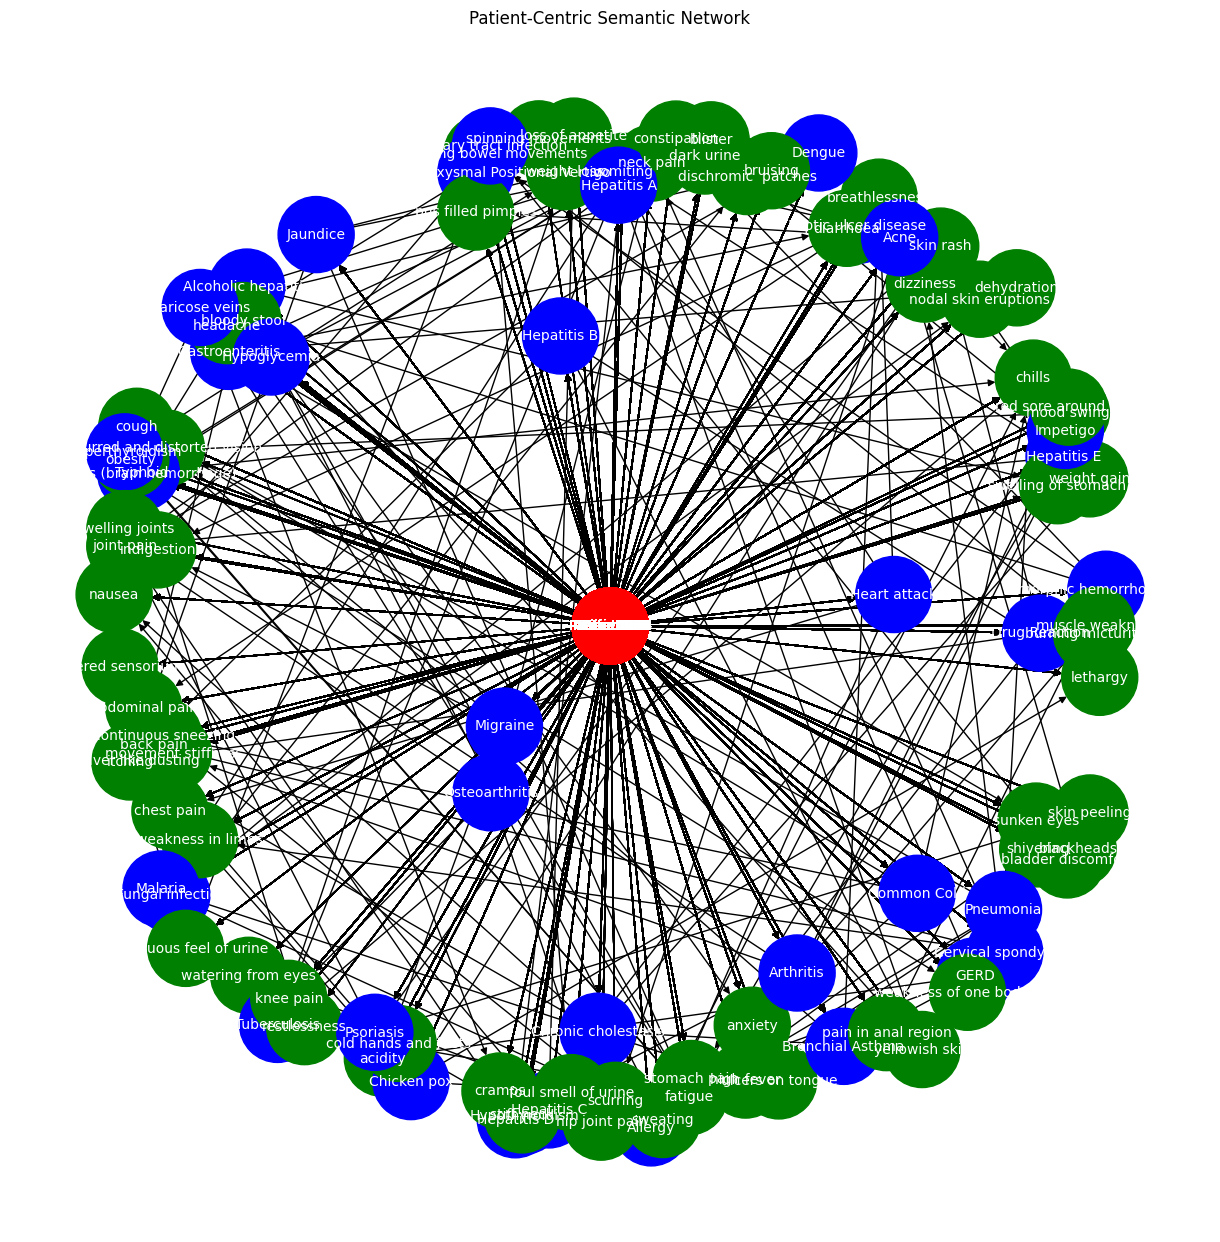

In [51]:
visualize_semantic_network(G_subset)

In [27]:
# Feature Extraction
def extract_features(symptoms, graph):
    features = []
    for symptom in symptoms:
        if symptom in graph:
            disease_neighbors = [n for n in graph.neighbors(symptom) if graph.nodes[n]['type'] == 'Disease']
            features.append(len(disease_neighbors))
        else:
            features.append(0)
    return features



In [29]:
# Preparing Data
X = []
y = []
for _, row in data.iterrows():
    symptoms = [s.strip() for s in row['Symptoms'].split(',')]
    features = extract_features(symptoms, G_subset)
    X.append(features)
    y.append(row['Disease'])



In [30]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


In [31]:
df_X = pd.DataFrame(X).fillna(0)

vectorizer = CountVectorizer()
X_symptoms = vectorizer.fit_transform(data['Symptoms'])

X_combined = pd.concat([df_X.reset_index(drop=True), pd.DataFrame(X_symptoms.toarray(), columns=vectorizer.get_feature_names_out())], axis=1)

X_combined.columns = X_combined.columns.astype(str)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_encoded, test_size=0.2, random_state=42)

# Pipeline with SMOTE
smote = SMOTE(random_state=42)
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', smote),
    ('clf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 10, 20, 30]
}



In [33]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'clf__max_depth': [None, 10, 20, 30],
                         'clf__n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [34]:
best_model = grid_search.best_estimator_

# Evaluation
accuracy = best_model.score(X_test, y_test)
print(f'Model Accuracy: {accuracy:.2f}')


Model Accuracy: 0.94


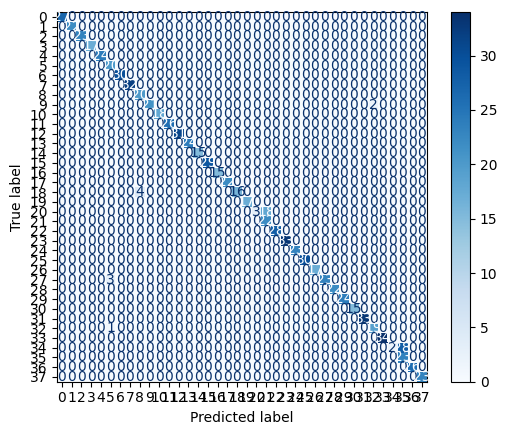

In [35]:

y_pred = best_model.predict(X_test)
unique_labels = sorted(set(y_test) | set(y_pred))

cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [36]:
report_dict = classification_report(y_test, y_pred, output_dict=True)
accuracy = report_dict['accuracy']
macro_avg = report_dict['macro avg']
weighted_avg = report_dict['weighted avg']
print(f"Accuracy: {accuracy:.2f}")
print(f"Macro Average - Precision: {macro_avg['precision']:.2f}, Recall: {macro_avg['recall']:.2f}, F1-Score: {macro_avg['f1-score']:.2f}")
print(f"Weighted Average - Precision: {weighted_avg['precision']:.2f}, Recall: {weighted_avg['recall']:.2f}, F1-Score: {weighted_avg['f1-score']:.2f}")



Accuracy: 0.94
Macro Average - Precision: 0.96, Recall: 0.94, F1-Score: 0.93
Weighted Average - Precision: 0.97, Recall: 0.94, F1-Score: 0.93


In [37]:
# Save Model Components
model_components = {
    'model': best_model,
    'vectorizer': vectorizer,
    'label_encoder': label_encoder
}

model_file_path = "model_components2.pkl"
with open(model_file_path, 'wb') as model_file:
    pickle.dump(model_components, model_file)


In [38]:
# Prediction Function with Top 3 Diseases
def predict_disease(symptoms):
    features = extract_features(symptoms.split(','), G_subset)
    features_df = pd.DataFrame([features]).fillna(0)
    features_vectorized = vectorizer.transform([', '.join(symptoms.split(','))]).toarray()
    features_vectorized_df = pd.DataFrame(features_vectorized, columns=vectorizer.get_feature_names_out())

    combined_features = pd.concat([features_df.reset_index(drop=True), features_vectorized_df], axis=1).reindex(columns=X_combined.columns, fill_value=0)

    disease_probs = best_model.predict_proba(combined_features)[0]
    top_3_indices = disease_probs.argsort()[-3:][::-1]
    top_3_diseases = label_encoder.inverse_transform(top_3_indices)

    top_disease = top_3_diseases[0]
    disease_info = data[data['Disease'] == top_disease].iloc[0]
    description = disease_info['Description']
    precautions = disease_info['Precautions']
    medications = disease_info['Medications']
    diet = disease_info['Diet']
    workout = disease_info['Workout']

    return top_3_diseases, description, precautions, medications, diet, workout


In [44]:
# Example Prediction
symptoms_input = "chills, vomiting, fatigue"
top_diseases, description, precautions, medications, diet, workout = predict_disease(symptoms_input)
print(f"Top 3 Predicted Diseases: {top_diseases}")
print(f"Details for {top_diseases[0]}: \nDescription: {description}\nPrecautions: {precautions}\nMedications: {medications}\nDiet: {diet}\nWorkout: {workout}")

Top 3 Predicted Diseases: ['Common Cold' 'Tuberculosis' 'Typhoid']
Details for Common Cold: 
Description: Common Cold is a viral infection of the upper respiratory tract.
Precautions: drink vitamin c rich drinks, take vapour, avoid cold food, keep fever in check
Medications: Antibiotics, Antiviral drugs, Antifungal drugs, IV fluids, Oxygen therapy
Diet: Cold Diet, Hydration, Warm fluids, Rest, Honey and lemon tea
Workout: Stay hydrated, Include nutrient-rich foods, Consume foods rich in vitamin C and antioxidants, Include zinc-rich foods, Limit sugary foods and beverages, Consume chicken soup, Consult a healthcare professional, Rest and conserve energy, Gradually resume normal diet, Follow medical recommendations
